# <font color="bordo">Programming Exercise 2 - Regularized Logistic Regression</font>

<p>
In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes QA.
<br>During QA, each microchip goes through various tests to ensure it is functioning correctly.

<p>
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. 
<br>From these two tests, you would like to determine whether the microchips should be accepted or rejected. 
<br>To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[0:6,:]) # print data samples
    return(data)

In [4]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

### Load data
<a id='regularized_load_data'></a>

In [5]:
data2 = loaddata('data/ex2data2.txt', ',')

('Dimensions: ', (118, 3))
[[ 0.051267  0.69956   1.      ]
 [-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [6]:
y = np.c_[data2[:,2]]
X = data2[:,0:2]

### Plot the data
<a id='regularized_plot_data'></a>
<p>
Our dataset cannot be separated into positive and negative examples by a straight-line through the plot. 
<br>Therefore, a straight-forward application of logistic regression will not perform well on this dataset
since logistic regression will only be able to find a linear decision boundary.

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


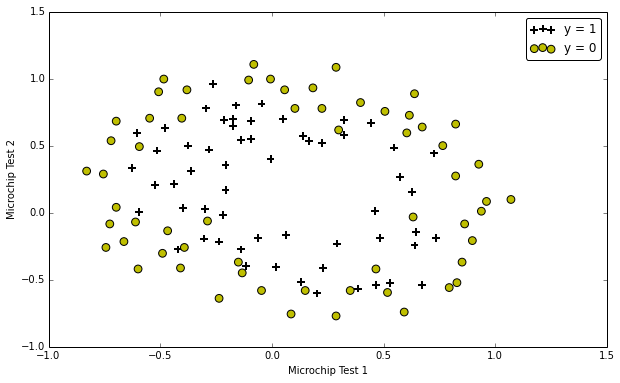

In [7]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

### Feature mapping

<p>
One way to fit the data better is to create more features from each data point.
<br>We will map the features into all polynomial terms of x 1 and x 2 up to the sixth power.

<p>
<img src="images/mapFeature_x.png" />

<p>
As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. 
<br>A logistic regression classifier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

<p>
While the feature mapping allows us to build a more expressive classifier, 
it also more susceptible to <font color="red">overfitting</font>. 
<br>In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

In [8]:
def mapFeatureVector(X1,X2):
    """
    Feature mapping function to polynomial features. 
    Maps the two features X1, X2 to polynomial features. 
    X1, X2 must be the same size.
    Returns -- New feature array with interactions and polynomial terms
    """
    
    degree = 6
    output_feature_vec = np.ones(len(X1))[:,None] # raw vector of ones (sizeof X1)

    for i in range(1,degree+1):
        for j in range(i+1):
            new_feature = np.array(X1**(i-j) * X2**j)[:,None]
            output_feature_vec = np.hstack((output_feature_vec, new_feature))
   
    return output_feature_vec

### Regularized Cost Function
<a id='regularized_cost_function'></a>
<p>
Recall that the regularized cost function in logistic regression is:
<p>
<font size="4em">$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$</font>

In [9]:
def costFunctionReg(theta, X, y, reg_param):
    """
    Computes loss using sum of square errors for logistic regression
    using theta as the parameter vector for linear regression to fit 
    the data points in X and y with penalty reg_param (lambda).
    """

    m = float(y.size) # number of training examples
    
    h = sigmoid(np.dot(X, theta)) # hypothesis
    
    # Cost function J(theta)
    reg_term = reg_param / (2*m) * np.sum(theta**2)
    
    J = (1/m) * np.sum(-y * np.log(h) - (1-y) * np.log(1-h)) + reg_term
    
    if np.isnan(J[0]):
        return(np.inf)
    return (J)

### Regularized Gradient Descent
<a id='regularized_gradient_descent'></a>
<p>
<u>Note</u>: you should not regularize the parameter $θ_0$.
<p>
For $j = 0$
<p>
<font size="4em">$\frac{\delta J(\theta)}{\delta\theta_{0}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j}$</font>
<p>
For $j >= 1$
<p>
<font size="4em">$\frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$</font>
<p>
Vectorized
<p>
<font size="4em">$\frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$</font>

In [10]:
def gradientReg(theta, X, y, reg_param):
    
    h = sigmoid(np.dot(X, theta)) # hypothesis
    
    # Vectorized implementation (replace with lines below)
    #grad_reg = (1/m) * X.T.dot(h-y) + (reg_param / m) * np.r_[[[0]],theta[1:].reshape(-1,1)]
    #return(grad.flatten())
    
    # Non-regularized
    grad_0 = (1/m) * np.sum( (h-y)[:,None] * X, axis=0 ) # sum over the row axis
    
    # Regularized
    grad_reg = grad_0 + (reg_param / m) * theta
    
    # Overwrite gradient for theta_0 with non-regularized gradient
    grad_reg[0] = grad_0[0]
    
    return(grad_reg)